
Spectrometer calibration
========================

Spectrometers are used to measure light. A probe is pointed at the light source and feeds the light sample through to the optical bench. The light hits a prism, or diffraction grating, and the spectrum of light is spread out accross a sensor that reports a measure related to the ammount of light that hits the sensor. 

Depending on your spectrometer, you may be need to calibrate it. Here's what we did step by step with our OceanOptics JAZ spectrometer to get units in W/cm2/nm. 


**OceanOptics JAZ**

<img src="../../img/jaz.png" alt="OceanOptics JAZ spectrometer" width=300>

Our JAZ spectrometer


Obtaining measurements
----------------------

OceanView software, matlab, etc. Easiest in Python. 

**`Seabreeze`**




In [1]:
from seabreeze import spectrometers

try:
    oo = spectrometers.Spectrometer.from_serial_number('JAZA1505')
    oo.integration_time_micros(1000*1000)  # 1 s
    wls = oo.wavelengths()
    counts = oo.intensities()

except KeyboardInterrupt:
    print('> Measurement terminated  by user')

finally:
    oo.close()
        


**`pyplr.oceanops.OceanOptics`**

Interface with more features

In [2]:
from pyplr import oceanops

try:
    oo = oceanops.OceanOptics.from_serial_number('JAZA1505')
    wls = oo.wavelengths()
    counts, info = oo.measurement(
        scans_to_average=3,
        box_car_width=3
    )

except KeyboardInterrupt:
    print('> Measurement terminated  by user')

finally:
    oo.close()



	Integration time: 1000 micros
	Maximum value: 5815.109075342466
	Integration time: 10142 micros
	Maximum value: 49609.09726027397
	Integration time: 12059 micros
	Maximum value: 55341.16541095891
> Computing average of 3 scans (integration_time=12852).



Wavelength calibration
----------------------

The pixels on a spectrometer CCD sensor are aligned to different wavelengths. The Jaz has 2048 pixels and reports wavelengths from ~330-1030 nm.

[According to Ocean Optics](https://www.oceaninsight.com/support/faqs/calibration/), the relationship between pixel and wavelength is described by a third-order polynomial:

\begin{equation}
\lambda_p = I + C_1 p + C_2 p^2 + C_3 p^3 
\end{equation}

Where:

  - $\lambda$ = wavelength of pixel $p$
  - $I$ = wavelength of pixel 0
  - $C1$ = first coefficient (nm/pixel)
  - $C2$ = second coefficient (nm/pixel$^2$)
  - $C3$ = third coefficient (nm/pixel$^3$)
  
The JAZ stores wavelength coefficients from when it was last calibrated, but wavelength calibrations are liable to drift over time due to various factors (e.g., mechanical shock, environmental conditions). 

The ground truth for wavelength calibration is dervied from sampling a light source that produces [spectral lines](https://en.wikipedia.org/wiki/Spectral_line), so we borrowed a [Philips argon lamp](http://www.lamptech.co.uk/Spec%20Sheets/D%20SP%20Philips%20LL%20Ar.htm) from our local physics department. 

<img width=300 src='../../img/jaz_argon_lamp.png'>


Measurement of the lamp produced a spectrum with lots of lines. I consulted the [NIST atomic spectra database](https://physics.nist.gov/PhysRefData/ASD/lines_form.html) to find the known positions of the lines. 

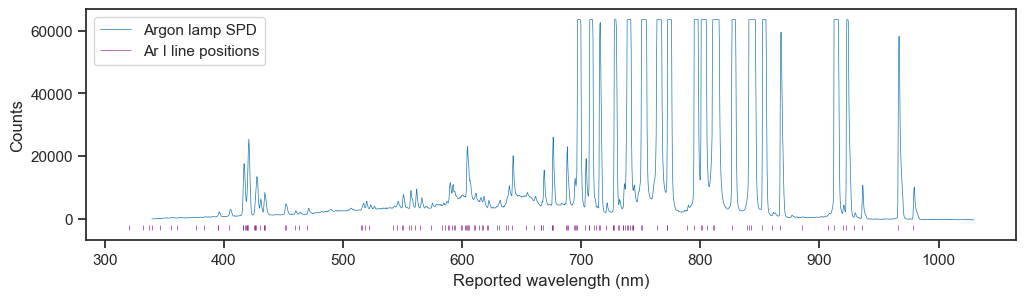

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
sns.set_context('notebook')

# Load sample and spectral lines
ar_spd = pd.read_csv('../../data/jaz/jaz_Ar_spd.csv', index_col='wl')
ar_lines = pd.read_csv('../../data/jaz/NIST_Ar_1_lines_300_1000.csv')

# Plot spd and line positions
fig, ax = plt.subplots(figsize=(12, 3))
ar_spd.pwr.plot(ax=ax, lw=.5, label='Argon lamp SPD')
ax.vlines(ar_lines['wl'], -3500, -2000, color='purple', lw=.4, label='Ar I line positions')
ax.set_ylabel('Counts')
ax.set_xlabel('Reported wavelength (nm)')
ax.legend();

Many of the lines were not resolved by the spectrometer, presumably due to undersaturation or pixel resolution limitations, but most tallied up with visible peaks. I used a peak-finding algorithm to try and find the corresponding peaks, based on certain criteria.

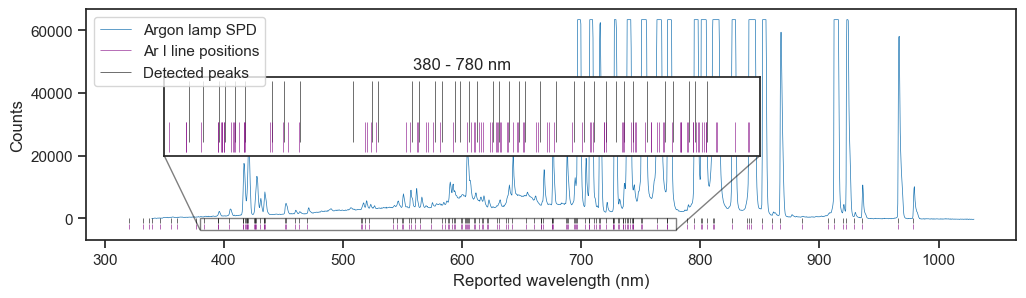

In [4]:
from scipy import signal

# Find peaks
peak_idxs = signal.find_peaks(ar_spd['pwr'], height=1800, prominence=300, threshold=30, distance=10)[0]
peaks = ar_spd.loc[ar_spd.pxl.isin(peak_idxs)].reset_index()
ax.vlines(ar_lines['wl'], -1500, 0, color='black', lw=.4, label='Detected peaks')

# Inset
axin = ax.inset_axes(bounds=[350,20000,500,25000], transform=ax.transData)
axin.vlines(peaks['wl'], -3000, 0, color='black', lw=.4, label='Detected peaks')
axin.vlines(ar_lines['wl'], -3500, -2000, color='purple', lw=.4, label='Ar I line positions')
axin.set_xlim((380, 780))
axin.set_xticks([])
axin.set_yticks([])
axin.set_title('380 - 780 nm')
ax.indicate_inset_zoom(axin, edgecolor="black", transform=ax.transData)
ax.legend()
fig

This showed a general pattern of rightward drift of about 1 nm, but the line pairing was not obvious so I zoomed in on a pdf plot and manually paired the detected peaks with the nearest line to the left, if there was one, dropping it otherwise.

In [5]:

# True line positions for selected peaks
true_wls = [
    394.8979, 404.4418, 415.859, 419.8317, 426.6286, 433.3561, 
    451.0733, 459.6097, 470.2316, 518.7746, 522.1271, 545.1652,
    549.5874, 560.6733, 565.0704, 573.952, 583.4263, 588.8584,
    599.8999, 603.2127, 610.5635, 617.3096, 621.5938, 630.7657,
    641.6307, 653.8112, 660.4853, 667.7282, 675.2834, 687.1289,
    693.7664, 703.0251, 714.7042, 720.698, 731.1716, 735.3293,
    743.6297, 789.1075, 860.5776, 866.7944, 919.4638, 935.422, 
    965.7786, 978.4503
]

# Remove suspect peaks without a true-line companion
drop_px = [448, 648, 947]
peaks = peaks.loc[~peaks.pxl.isin(drop_px)] 
peaks['true_wl'] = true_wls


Now calculate the wavelength coefficients and predict the new values.

In [6]:
poly = np.polyfit(peaks['pxl'], peaks['true_wl'], deg=3)
print('> The wavelength coefficients are:\n')
print(*poly[::-1], sep='\n')
calibrated_wls = np.polyval(poly, ar_spd.pxl)


> The wavelength coefficients are:

338.5374924539017
0.3802367113739599
-1.5959354792685768e-05
-2.507246200675931e-09


These coefficients can be updated in the spectrometer using Ocean Optics software, or the new wavelengths can be applied at a later stage of processing.


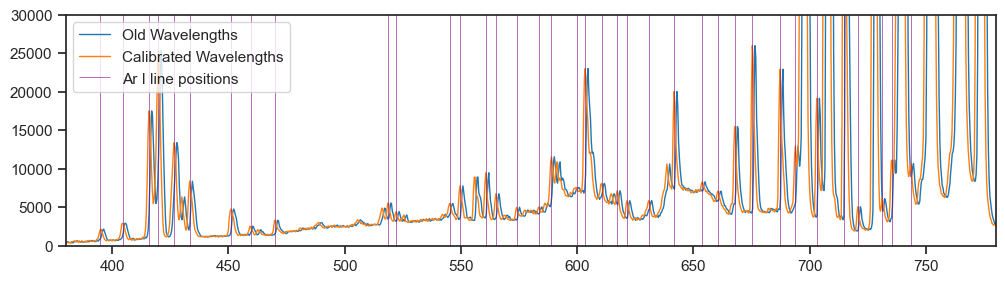

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.plot(ar_spd.index, ar_spd.pwr, lw=1, label='Old Wavelengths')
ax.plot(calibrated_wls, ar_spd.pwr, lw=1, label='Calibrated Wavelengths')
ax.vlines(true_wls, 0, 60000, color='purple', lw=.4, label='Ar I line positions')
ax.set_xlim((380, 780))
ax.set_ylim((0, 30000))
ax.legend(loc='upper left');

In the end it was a lot of effort for a small correction, but worth it!


Absolute irradiance calibration
-------------------------------

The raw spectrum reported by the JAZ is in *count* units, which is a measure relating to the number of photons hitting each pixel on the sensor. Dividing the reported counts by the integration time gives $counts/s$, and further dividing by the wavelength spread (how many nanometers each pixel represents) gives $counts/s/nm$. 

Absolute irradiance calibration allows for measurements to be reported in energy units, such as $\mu W/cm^2/nm$, which can be preferable. This is achieved by taking a reference measurement of a radiometrically calibrated light source with known power output and then working out, for each pixel, the uJ/count ratio. 

[According to Ocean Optics](https://www.oceaninsight.com/support/faqs/calibration/), with the $\mu J/count$ ratio for each pixel, one can convert to energy units using this forumla:

\begin{equation}
I_p = (S_p - D_p) * C_p / (T * A * dL_p)
\end{equation}

Where:

  - $C_p$ = calibration file, in μJ/count (specific to the sampling optic)
  - $S_p$ = sample spectrum in count units
  - $D_p$ = dark spectrum in count units (electrical noise floor)
  - $T$ = integration time in seconds
  - $A$ = collection area in cm$^2$
  - $dL_p$ = wavelength spread

Our NIST-traceable HL-2000-CAL light source is suitable for absolute irradiance calculation. It has a tungsten-halogen bulb and came with calibration files expressing its absolute intensity values at certain wavelengths in $\mu W/cm^2/nm$ when measured with a fibre optic probe or cosine corrector (the sampling optic affects the measured power).

It is relatively easy to perform an absolute irradiance calibration with the [Ocean View software](https://www.oceaninsight.com/products/software/acquisition-and-analysis/oceanview/), which is available for a 30-day free trial. 

Turn the light source on and wait for it to reach thermal equilibrium (~15 mins) and then select the *Absolute Irradiance Calibration* option. The software guides you through the process of taking a reference measurement, a dark measurement to compensate for electrical noise in the CCD, uploading the relevant lamp calibration file, and obtaining the $\mu J/count$ pixel calibration file.

<img width=400 src='../../img/jaz_hl_2000_cal.png'>

The calibration output looks like this.

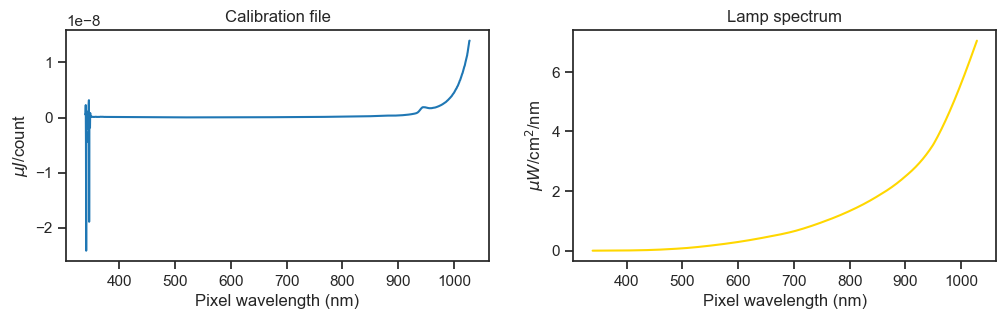

In [8]:
ov_cal_file = pd.read_table('../../data/jaz/JAZ_OOIIrrad.cal', skiprows=8).squeeze()
lamp_preview = pd.read_table('../../data/jaz/JAZ_LampIntensityPreview.txt', skiprows=8)
lamp_preview.columns = [s.strip(' ') for s in lamp_preview.columns]
lamp_preview = lamp_preview.set_index('Wavelength')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ov_cal_file.plot(ax=ax1, xlabel='Pixel wavelength (nm)', ylabel='$\mu J$/count', title='Calibration file')
lamp_preview.plot(ax=ax2, c='gold', xlabel='Pixel wavelength (nm)', ylabel='$\mu W$/cm$^2$/nm', title='Lamp spectrum', legend=False);

Here's how to perform the irradiance calibration without using Ocean View. 

Hit enter to obtain reference measurement: 


	Integration time: 1000 micros
	Maximum value: 6126.648031919712
	Integration time: 9627 micros
	Maximum value: 47894.856846209615
	Integration time: 11855 micros
	Maximum value: 57838.88130044776
> Computing average of 3 scans (integration_time=12089).


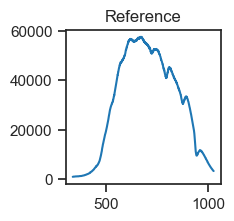

Now block all light and hit enter to obtain dark counts: 


	Integration time: 12089 micros
	Maximum value: 1253.7149531154294
> Computing average of 3 scans (integration_time=12089).


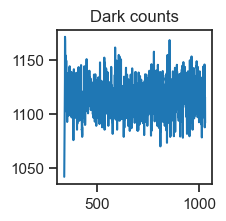

> Closing connection to spectrometer


In [9]:
from scipy import interpolate

from pyplr.oceanops import OceanOptics


try:
    # Connect to JAZ
    oo = OceanOptics.from_serial_number('JAZA1505')

    # Perform reference measurement
    input('Hit enter to obtain reference measurement:')
    reference_counts, reference_info = oo.measurement(
        correct_nonlinearity = True,
        correct_dark_counts = False,
        scans_to_average=3,
        box_car_width=3
    )
    reference_counts.plot(figsize=(2, 2), title='Reference')
    plt.show()

    # Perform dark measurement
    input('Now block all light and hit enter to obtain dark counts:')
    dark_counts, dark_info = oo.measurement(
        correct_nonlinearity = True,
        correct_dark_counts = False,
        integration_time = reference_info['integration_time'],
        scans_to_average=3,
        box_car_width=3
    )
    dark_counts.plot(figsize=(2, 2), title='Dark counts')
    plt.show()

    # Load lamp file and resample to pixel wavelengths
    lamp_file = pd.read_table('../../data/jaz/030410313_FIB.LMP', header=None)
    lamp_file.columns = ['Wavelength', 'uJ/cm2']
    lamp_file = lamp_file.squeeze()
    interp_func = interpolate.interp1d(lamp_file['Wavelength'], lamp_file['uJ/cm2'])
    wavelengths = reference_counts.index
    resampled_lamp_data = interp_func(wavelengths)     

    # Calculate scaling parameters
    integration_time = reference_info['integration_time'] / 1e6  # Microseconds to seconds
    fibre_diameter = 400 / 1e4  # Microns to cm
    collection_area = np.pi * (fibre_diameter/2) ** 2  # cm2
    wavelength_spread = np.hstack(
        [(wavelengths[1] - wavelengths[0]),
         (wavelengths[2:] - wavelengths[:-2]) / 2,
         (wavelengths[-1] - wavelengths[-2])
        ]
    )

    # Make the calibration file. To do this we change the formula above.
    calibration_file = (
        resampled_lamp_data
        / ((reference_counts - dark_counts)
           / (integration_time
              * collection_area
              * wavelength_spread)
          )
    )

except KeyboardInterrupt:
    print('> Calibration terminated by user')

except Exception as e:
    print('> Something else went wrong')
    raise e

finally:
    oo.close()
    print('> Closing connection to spectrometer')



Let's compare to the Ocean View calibration, focusing on the bits that matter


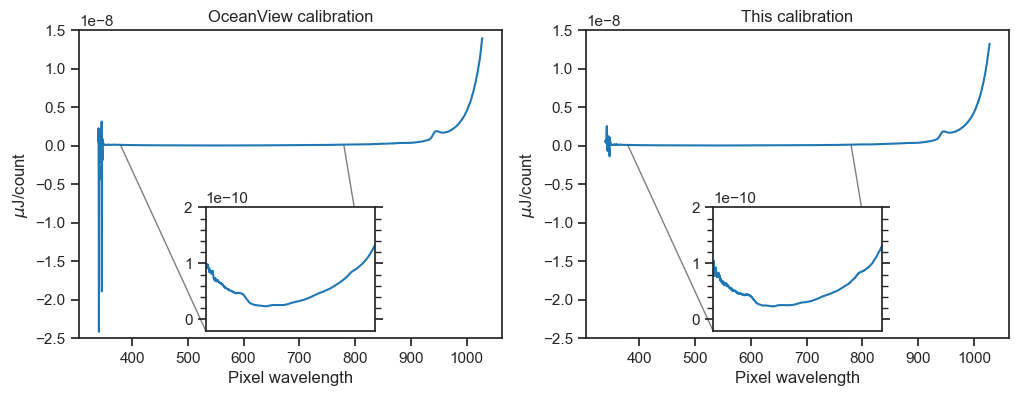

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import (
    mark_inset, 
    inset_axes
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ov_cal_file.plot(ax=ax1, title='OceanView calibration', legend=False)
axins1 = inset_axes(ax1, '40%', '40%', loc='lower center')
ov_cal_file.plot(ax=axins1, legend=False)

calibration_file.plot(ax=ax2, title='This calibration')
axins2 = inset_axes(ax2, '40%', '40%', loc='lower center')
calibration_file.plot(ax=axins2, legend=False)

for axins in [axins1, axins2]:
    axins.set_xlim(380, 780)
    axins.set_ylim(-.002e-8, .02e-8)
    axins.set_xticklabels([])
    axins.minorticks_on()
    axins.tick_params(which='both', bottom=False, right=True)

for ax, axins in zip([ax1, ax2], [axins1, axins2]):
    ax.set_ylim((-2.5e-8, 1.5e-8))
    ax.set_ylabel('$\mu$J/count')
    ax.set_xlabel('Pixel wavelength')

    ax.indicate_inset_zoom(
        axins, 
        edgecolor="black",
        transform=ax.get_xaxis_transform()
    )    


Very much the same for visible wavelengths.

The final test...

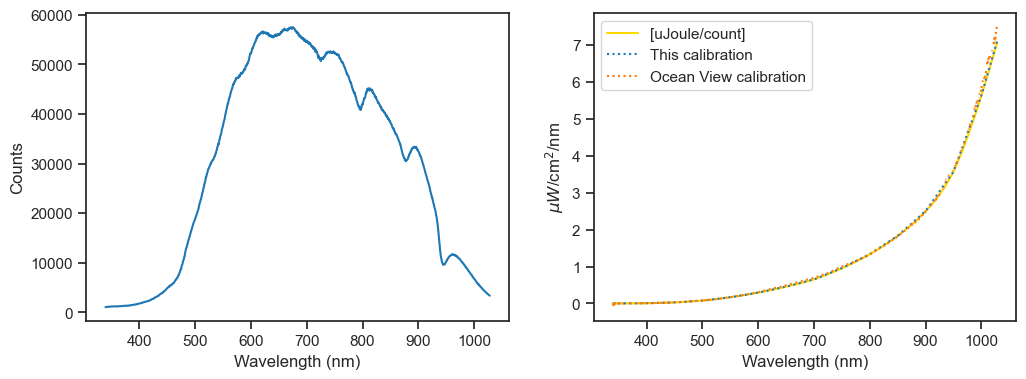

In [11]:
# We change this and use the original formula
this_calibration_spectrum = (
    (reference_counts - dark_counts)
    * (calibration_file
       / (integration_time
          * collection_area
          * wavelength_spread)
      )
)

ov_calibration_spectrum = (
    (reference_counts - dark_counts)
    * (ov_cal_file
       / (integration_time
          * collection_area
          * wavelength_spread)
      )
)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
reference_counts.plot(ax=ax1)
lamp_preview.plot(ax=ax2, c='gold', xlabel='Wavelength (nm)', label='Ocean View lamp profile')
this_calibration_spectrum.plot(ax=ax2, ls=':', label='This calibration')
ov_calibration_spectrum.plot(ax=ax2, ls=':', label='Ocean View calibration')
ax1.set_ylabel('Counts')
ax2.set_ylabel('$\mu W$/cm$^2$/nm')
plt.legend()

for ax in [ax1, ax2]:
    ax.set_xlabel('Wavelength (nm)');

In [12]:
lamp_preview

,[uJoule/count]
Wavelength,
339.117812,0.001345
339.496633,0.001370
339.875426,0.001394
340.254190,0.001412
340.632925,0.001425
...,...
1027.022825,6.986814
1027.304744,7.001711
1027.586598,7.016616
